<a href="https://colab.research.google.com/github/sadVries/PRA3024/blob/main/PRA3024_2324_Cosmology_Sjoerd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='deepskyblue'>Cosmology MCMC notebook </font>

## <font color='deepskyblue'>Preliminaries</font>

In [1]:
# Install required packages (if not available on server)
try:
  import getdist
except:
  !pip install getdist
  import getdist

# Load required packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate

# import pylab
import getdist, IPython, time
from numpy import random

# from IPython.display import Image
from getdist import plots, MCSamples, loadMCSamples

# just for printing! calculations should be performed with machine precision
%precision 3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.1/826.1 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for getdist: filename=getdist-1.4.7-py3-none-any.whl size=810431 sha256=573a656f02224b6ec3c376fc5bda1c788b2ff18e6f55f2e489c83e53ed0b2a75
  Stored in directory: /root/.cache/pip/wheels/11/3e/8d/93c9494b4587d95165f805b376a4c7ed3ae670eb3cf7397389
Successfully built getdist


'%.3f'


<font color='tomato'>
(NB: The equations you'll directly need to build your code are those $\boxed{\text{with a box around}}$)
</font>

## <font color='deepskyblue'>The $\Lambda$CDM Model</font>

The Lambda-Cold-Dark-Matter ($\Lambda$CDM) Model is our concordance cosmological model. It postulates a Universe that behaves according to **General Relativity**, filled with **baryons** (protons, neutrons - the stuff we and stars are made of!), **Cold Dark Matter (CDM)** and a **Cosmological Constant** $\Lambda$.

The expansion of the Universe is best described in terms of the **scale factor** $a$ (the "radius" of the Universe, conventionally set to 1 today) and the **Hubble rate** $H$. While photons (light rays) travel in the expanding universe they get redshifted, and this redshift is directly related to the size of the Universe when the photon was emitted compared to today:

$$ \frac{\lambda_{\rm obs}}{\lambda_{\rm em}} \equiv 1 + z_{\rm em} = \frac{1}{a_{\rm em}}$$


In the $\Lambda$CDM model (and at late enough times), this additionally simplifies to

$$
\begin{gathered}
\boxed{
H^2 = H_0^2\left[\Omega_\Lambda + \Omega_m (1+z)^3 + \Omega_k (1+z)^2\right]
}
\\
\boxed{
\Omega_m + \Omega_\Lambda + \Omega_k = 1
}
\end{gathered}
\tag{1}
$$

$H_0$ is the value of the Hubble rate *today*, and the parameters $\Omega_m$, $\Omega_\Lambda$ and $\Omega_k$ are dimensionless quantities indicating how much of the present expansion of the Universe is due to (non-relativistic) matter, cosmological constant $\Lambda$, and spatial curvature $k$. Note that the three $\Omega$'s are *not independent* (their sum is 1) and that we grouped together the contribution of baryons and CDM,

$$
\Omega_m = \Omega_{\rm CDM} + \Omega_{\rm b}
$$

and that we have evidence that independent evidence that $\Omega_b \approx 5$\%. NB: only $\Omega_m \geq 0$ makes physical sense, while in principle both $\Omega_\Lambda$ and $\Omega_k$ can be negative.

The present Hubble rate is conventionally parametrised in terms of the dimensionless $h$:

$$
\boxed{
  H_0 \equiv 100\,h\,\frac{\rm km}{\rm s\,Mpc}
}
\tag{2}
$$

where Mpc = Megaparsec and [parsec](https://en.wikipedia.org/wiki/Parsec) equals to about $3.26$ light years or $3.086 \cdot 10^{16}$ m.

In essence, these equations give us the relation between *what exists in the Universe* and *how the Universe expanded*. Measure one, I can tell you the other. This is precisely what we aim to do!

Time to define the function $H(z)$. Don't forget to include the useful parameters as arguments of the function, and to define `parsec`.

In [2]:
import math

In [3]:
# Hubble rate: look at equations (1) and (2) for the definition!
def Hubble(z, omega_L, omega_M, H0):
  omega_K = 1 - omega_M - omega_L
  return np.sqrt(H0**2 * (omega_L + omega_M*(1+z)**3 + omega_K*(1+z)**2)) # <--- YOUR CODE GOES HERE!

In [4]:
OmegaL = 0.7
OmegaM = 0.3
h0 = 0.67

zs = np.arange(0, 1.4, 0.1)
Hs = []
for z in zs:
  Hs += [Hubble(z, OmegaL, OmegaM, h0)]

plt.scatter(zs, Hs)
plt.xlabel('z')
plt.ylabel('H(z)')
plt.show()

In [5]:
print(Hubble(3.1, .3, .4, 70))

401.57920762908026


## <font color='deepskyblue'>Supernovae Ia</font>

In order to track the expansion of the Universe, we will look at Supernovae type Ia observations. SNIa are formed when a *white dwarf* accretes matter from a companion until it reaches a critical mass of about $1.44 M_\odot$ (solar masses), after which it explodes **at always the same luminosity** $L_{\rm SN}$. Therefore, the observed [magnitude](https://en.wikipedia.org/wiki/Magnitude_(astronomy)) is only a function of their [**luminosity distance**](https://en.wikipedia.org/wiki/Distance_measures_(cosmology)) from Earth, defined as the ratio of the intrinsic luminosity $L_{\rm SNIa}$ and the measured *surface brightness* $\Phi$ (energy per unit time per unit area)

$$ d_L\equiv \frac{L_{\rm SN}}{4\pi \Phi} $$

We can express the luminosity distance in terms of the Hubble rate:

$$
\boxed{
d_L(z) = \frac{c}{H_0}(1+z) \times
\begin{cases}
    \cfrac{1}{\sqrt{\Omega_k}} \,\sinh\left(\sqrt{\Omega_k}\,D(z)\right) & \Omega_k > 0
    \\[.5em]
    D(z) & \Omega_k = 0
    \\[.5em]
    \cfrac{1}{\sqrt{-\Omega_k}} \,\sin\left(\sqrt{-\Omega_k}\,D(z)\right) & \Omega_k < 0
\end{cases}
\qquad\qquad
D(z) \equiv H_0\int_0^z \frac{{\rm d}Z}{H(Z)}
}
\tag{3}
$$

where $c$ is the speed of light: $c \simeq 2.998 \cdot 10^{5}$ km/s.

Clearly, there exists a relation between $d_L(z)$ and $H(z)$, so the luminosity distance is a useful measure of the Universe expansion history.
In practice, however, the actual observable for [Supernovae Type Ia](https://en.wikipedia.org/wiki/Type_Ia_supernova) (or SNIa) is the [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) $\mu$, defined as the difference between the *apparent magnitude* $m$ and the *absolute magnitude* $M$:

$$
\boxed{
\mu(z) \equiv m(z) - M \equiv 5 \log_{10} \frac{d_L(z)}{10\,\text{pc}}
}
\tag{4}
$$

We can create the function `dL(z, h, Omega_m, Omega_Lambda)`. You can also pass the function `Hubble` as an argument: `dL(z, Hubble, Omega_m, Omega_Lambda)`. Additionally, you can create $D(z)$ for your convenience.

Note that you need to integrate the function $H(z)$, so write your own quick-and-easy numerical integrator, for example implementing the [trapezoidal rule](https://en.wikipedia.org/wiki/Trapezoidal_rule) or your favourite alternative, or [look up the pre-written methods](https://docs.scipy.org/doc/scipy/tutorial/integrate.html). Make sure it returns $d_L$ in parsecs and that it uses $H_0$ measured in units of 100 km/s/Mpc (which we called $h$).

In [6]:
SPEED_OF_LIGHT = 2.998e5 # <--- Choose your favourite units, but make sure you're consistent!

# Integrate 1/H from x = 0 to x = z
def D(z,OmegaL, OmegaM, h0): # Yes, you can pass a function as argument!
    # This is how you integrate with integrate.quad;
    # (...)[0] gives the result of the integral; (...)[1] is the error estimate; see manual for details
    return h0 * integrate.quad(lambda x: 1/Hubble(x, OmegaL, OmegaM, h0), 0, z)[0]

# Let's just print a sample result

def dL(z, OmegaL, OmegaM, h0): # luminosity distance, use eq.(3)
  Omegak = 1. - OmegaM - OmegaL
  Dz = D(z,OmegaL, OmegaM, h0)

  if (Omegak > 0):
    dL = 1/np.sqrt(Omegak) * np.sinh(np.sqrt(Omegak)*Dz)
  if (Omegak == 0):
    dL = Dz
  if (Omegak < 0):
    dL =1/np.sqrt(-Omegak) * np.sin(np.sqrt(-Omegak)*Dz)
  dL = 10.**4 *SPEED_OF_LIGHT / h0 *(1+z) * dL
  return (dL)



def mu(z, OmegaL, OmegaM, h0):

  return 5. * np.log10( dL(z, OmegaL, OmegaM, h0) / 10. )



In [7]:
OmegaL = 0.7
OmegaM = 0.3
h0 = 70

zs = np.arange(0, 1.4, 0.1)
dLs = []
for z in zs:
  dLs += [dL(z, OmegaL, OmegaM, h0)]


print(dLs)
plt.scatter(zs, dLs)
plt.xlabel('dLs')
plt.ylabel('H(z)')
plt.show()

[0.0, 4603115.163419667, 9800925.428293873, 15527549.92931852, 21722193.191614453, 28330093.63268413, 35302817.21963303, 42598085.9452175, 50179321.209565856, 58015044.9981269, 66078238.432873644, 74345719.42831291, 82797572.83371149, 91416647.38925877]


In [8]:
OmegaL = 0.7
OmegaM = 0.3
h0 = 70

zs = np.arange(0.1, 1.4, 0.1)
Mus = []
for z in zs:
  Mus += [mu(z, OmegaL, OmegaM, h0)]


print(Mus)
plt.scatter(zs, Mus)
plt.xlabel('dLs')
plt.ylabel('${\mu}$[z]')
plt.show()

[28.315259202312607, 29.956335424088095, 30.955514672036067, 31.684518359402173, 32.26124004946256, 32.73904682072394, 33.14695042719137, 33.502623910945786, 33.817703167156935, 34.100292283465386, 34.35627984195091, 34.590088029312334, 34.80512644972808]


## <font color='deepskyblue'>The Union2.1 Compilation</font>

Our source of data is from [Union2.1](http://supernova.lbl.gov/Union/). It is a collection of $580$ SNIa, each observation is comprised of redshift $z$
Our goal today is to use SNIa measurements to constrain the parameters ($h, \Omega_\Lambda, \Omega_m$).

In essence, we can calculate for each redshift the theoretical value of $\mu$ using this equation with the expression for $d_L(z)$ and our model of choice $H(z)$ -- note that we will need to perform a numerical integral! -- and compare this value with observations. A different model would amount to changing the theoretical value of $H(z)$.

Let us start by importing and plotting the data:

In [9]:
dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"

# Read in data as numpy array.
# Format is [name, redshift, magnitude, magnitude error, and another number?]
data = np.genfromtxt(dataloc)

# Print the first line as an example. (Note that genfromtxt turns the names into 'Not A Number')
display(data[0])

array([      nan, 2.849e-02, 3.535e+01, 2.239e-01, 1.284e-01])

In [10]:
# Extract the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
# Data are in columns, so we either slice it by columns: arr[:,n]...
zs = data[:,1] # redshift

# ...or transpose the array and then slice by row: arr_transposed[n]
distance_modulus = data.T[2] # distance modulus
error_distance_modulus = data.T[3] # errors on distance modulus = sigmas

In [11]:
# Let's look at the data, just for fun.
# We can look both at the raw data (distance modulus) or calculate the luminosity distance
# Note that Numpy allows us to manipulate whole arrays at once with something like:
#     array_2 = some_function_of(array_1)

# luminosity distance in Mpc
luminosity_distance_pc = 1.E-5 * 10.**(distance_modulus / 5.)

In [12]:
(data)

array([[      nan, 2.849e-02, 3.535e+01, 2.239e-01, 1.284e-01],
       [      nan, 5.004e-02, 3.668e+01, 1.668e-01, 1.284e-01],
       [      nan, 5.293e-02, 3.682e+01, 1.558e-01, 1.284e-01],
       ...,
       [      nan, 8.210e-01, 4.364e+01, 1.940e-01, 5.517e-01],
       [      nan, 1.215e+00, 4.525e+01, 5.603e-01, 1.477e-04],
       [      nan, 6.230e-01, 4.251e+01, 2.414e-01, 5.517e-01]])

In [ ]:
# Recommendation: you might want to try your functions here, and check that for Omega_m = 0.3 and Omega_L = 0.7 you get a decent match to the data
%matplotlib inline
#plt.scatter(zs,distance_modulus)
OmegaL = 0.7
OmegaM = 0.3
h0 = .70

zvalues = np.arange(0.01, 1.5, 0.01)
DLS = []
for i in zvalues:
  DLS.append(dL(i,OmegaL, OmegaM, h0))

MUS = []

for i in zvalues:
  MUS.append(mu(i,OmegaL, OmegaM, h0))

plt.plot(zvalues, MUS)
plt.errorbar(zs, distance_modulus, yerr = error_distance_modulus, fmt=" ", ecolor= "purple", capsize= 2.5 )

plt.show()
# Plot distance modulus versus redshift (original data)
print(len(distance_modulus))

## <font color='deepskyblue'>Bayes' Theorem: Likelihood, Prior, Posterior (and Evidence...)</font>

The **conditional probability of A given that B is true** is denoted with $P(A|B)$ (read: *probability of A given B*).
Did A happen? Then B has probability $P(B|A)$ of happening.

[**Bayes' Theorem**](https://en.wikipedia.org/wiki/Bayes%27_theorem) is simply a reflection of the symmetry of the concept of joint probability:

$$
P(A|B)P(B) = P(B|A)P(A)
$$

In physics, our goal is often to determine how likely the values of some parameters $\theta$ are, given how well they reproduce the data $D$.
We write Bayes' theorem in the following equivalent form:

$$
P(\theta | D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$

The various terms conventionally take the names:

$$
\begin{aligned}
P(\theta | D) & && \text{Posterior}
\\
P(D | \theta)& && \text{Likelihood}
\\
P(\theta) & && \text{Prior}
\\
P(D) & && \text{Evidence}
\end{aligned}
$$

### <font color='deepskyblue'>Prior</font>

The *prior* quantifies our degree of prior belief in the model parameters. It can contain the results of previous experiments, or theoretical considerations (for instance, that certain parameters cannot be negative, etc.).

We can have *strong priors* about something - the Sun still existing at night, see the comic below - or not.
When we do *not* have compelling prior knowledge about a parameter, we generally use a *non-informative* prior probability distribution, most often related to the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution)

$$
\begin{aligned}
    \text{Uniform} & && \theta \in \text{Uniform}[\theta_{\rm min}, \theta_{\rm max}]
    \\
    \text{Log Uniform} & && \log\theta \in \text{Uniform}[\log\theta_{\rm min}, \log\theta_{\rm max}]
\end{aligned}
$$

You may sometimes hear that "the prior doesn't matter". While this is not strictly true, it is however true that in many instances the *likelihood* depends more dramatically on the parameters and will have a dominating contribution to the posterior. You are more than welcome to try different priors for the model parameters and see if and how your results change.

### <font color='deepskyblue'>Likelihood</font>

The measure of how well our model reproduces the data is the **likelihood** $\mathcal L$. For normal (=Gaussian), uncorrelated data $\mu_i$ with errors $\sigma_i$ ($i = \{1,580\}$), the likelihood is related to the famous [**chi-squared**](https://en.wikipedia.org/wiki/Chi-square_distribution) via

$$
P(D | \theta) \equiv \mathcal L = \exp\left(-\frac{\chi^2}{2}\right)
\qquad
\qquad
\boxed{
\chi^2 \equiv \sum_{i=1}^{580} \frac{\left(\mu_i^{(\rm theor)} - \mu_i^{(\rm obs)}\right)^2}{\sigma_i^2}
}
\tag{5}
$$

A *high likelihood* corresponds to a *low chi squared*.

In principle, we could attack the problem brute-force: create a grid of values for $h$, $\Omega_m$, $\Omega_\Lambda$, calculate the likelihood for each combination, and create a profile for the likelihood.

In practical cases, however, this is not only sub-optimal but sometimes **impossible**. Think of complicated models with 20+ free parameters (this is not unheard of, by the way). Even a very coarse grained grid of 100 values for each parameter would result in more than $10^{40}$ (!!!) different parameter combination to be tested. You can probably understand why this is undesirable.

### <font color='deepskyblue'>Evidence</font>

This is the tricky bit. The evidence, which is "*the probability of observing certain data*", is not something that is easy to evaluate or interpret. This looks like a serious limitation to finding the:


### <font color='deepskyblue'>Posterior</font>

What does the data tell us about the model parameters? The answer is the *posterior probability distribution*, often (but not necessarily) expressed as (average $\pm$ standard deviation)

$$
\theta_i = \bar\theta_i \pm \sigma_i
$$

In other words, the posterior tells us how likely it is for the model parameters to have certain values, *given that we observe the data* $D$.

*This is the final goal of our analysis!*

<br>




## <font color='deepskyblue'>Markov-Chain Monte Carlo</font>

Markov-Chain Monte Carlo techniques are a class of methods to sample a probability distribution $P(x)$ - in our case $P(\theta | D)$ - provided that we can calculate a density $\mathcal F(x)$ **that is proportional to it** - in our case $P(\theta)P(D|\theta)$ = likelihood $\times$ prior. Among these, a very popular one is the [**Metropolis-Hastings**](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, which is what we will use.

Schematically, the algorithm works as follows:
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and calculate the $\mathcal F_{\rm old}$
* Propose a new set of parameters $\theta_{\rm prop}$, calculate the new corresponding $\mathcal F_{\rm prop}$. How you propose the new parameters is not essential as long as the probability of going from one set of parameters to the next is the same as the inverse: $P(\theta_a \to \theta_b) = P(\theta_b \to \theta_a)$. For this, we normally take Gaussian displacements with some (relatively small) standard deviation.
* Compare the new and old likelihoods-priors:
    * If $\mathcal F_{\rm prop} > \mathcal F_{\rm old}$, accept the step: $\theta_{\rm new} = \theta_{\rm prop}$
    * Otherwise, accept with probability $P_{\rm accept} = \mathcal F_{\rm prop}/\mathcal F_{\rm old}$
* If accepted, $\theta_{\rm new} = \theta_{\rm prop}$ and record the step; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Update $\theta_{\rm old} = \theta_{\rm new}$
* Repeat

The MC chain keeps going until the desired number of steps or, ideally, when a suitable convergence test, like for example the [Gelman-Rubin test](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html), is satisfied.
Today we will just set a limit to the total number of steps, but please feel free to implement and test your favourite convergence test!

Looking at equation (5), you can convince yourself that
$$
\frac{\mathcal L_a}{\mathcal L_b} = \exp\left(\frac{\chi_b^2 - \chi_a^2}{2}\right)
$$

(This is useful because $\chi^2$ can be large, so we want to avoid the likelihoods evaluating to `0.` -- computers don't like dividing by zero, unfortunately)


* <font color="deepskyblue"> Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and the corresponding chi squared $\chi_{\rm old}^2$ (to be clear, for us this implies calculating a series of 580 integrals and comparing each with the observed values) </font>
* <font color="deepskyblue"> Propose new parameters $\theta_{\rm prop}$ and calculate the corresponding chi squared $\chi_{\rm prop}^2$</font>
* <font color="deepskyblue"> Draw a random number $r \in [0,1]$</font>
* <font color="deepskyblue"> Accept the step if
$$
r < \exp\left(\frac{\chi_{\rm old}^2 - \chi_{\rm prop}^2}{2}\right) \frac{P(\theta)_{\rm prop}}{P(\theta)_{\rm old}}
$$</font>
    * <font color="deepskyblue"> If accepted, update $\theta_{\rm old} = \theta_{\rm prop}$</font>
    * <font color="deepskyblue">If you want, you can keep a record of the best fit (lowest $\chi^2$), but this is not the specific purpose of MCMC! We are exploring the parameter space and sampling a _posterior distribution_, not just finding the best fit</font>
* <font color="deepskyblue"> Record the step - including **re-recording** if the step was not accepted! </font>
* <font color="deepskyblue"> Repeat</font>

Good Day Lorenzo,

For my code i made it so the gaussian for the prediction gets smaller. This should make it better and more acurate.
And i added in random values to keep for 25 repitions every 100(at random)
i wanted to do more but due to personal reason i did not have much time for commenting and further analysis, my apologies


In [14]:
# You don't actually need to write your data on a file (you could just store it in some np.array)
# but it tends to be a good idea, so that you run a good, long MCMC once, and then you can do all the
# analysis later on at any time, without having to produce the data again

# Choose your favourite filename
filename = "MC_Chain_SNIa.txt"
file = open(filename, "w")

# A few thousand is a decent ballpark for the length of your MCMC chain
# NB: a few thousand *ACCEPTED* steps, not just attempted
N_steps = 25000

# Start from some very bad values, to show that the MCMC works anyway!
# (making sure you don't divide by zero anywhere...)
Omega_M = 0.1
Omega_L = 0.1
h = 0.1

# This is the main component of the exercise:
# PUT YOUR MCMC CODE HERE!

chi2_total_best = 999999999
chi2_total_list = []

hList = []
Omega_Mlist = []
Omega_Llist = []
i = 0
changing_random = 0.1
random_i = 1


#fig, ax = plt.subplots()

for i in range(N_steps):

    # pick a random step for all starting values

    if i % 250 == 0 and i != 0:
      print(i)
    if i % 10000 == 0 and i != 0:

      changing_random = changing_random/10

    Omega_M_new = Omega_M + np.random.normal(0, changing_random)
    Omega_L_new = Omega_L + np.random.normal(0, changing_random)
    h_new       = h       + np.random.normal(0, changing_random)
    if(Omega_M_new < 0.0) or (Omega_L_new < 0.0) or (h_new < 0.0) : continue

    # loop over all datapoints
    chi2_total = 0.

    for j in range(len(zs)) :
        mu_model = mu(zs[j], Omega_L_new, Omega_M_new, h_new)
        chi2 = (mu_model - distance_modulus[j])**2 / error_distance_modulus[j]**2
        chi2_total += chi2

    if np.isnan(chi2_total) : continue

    Omega_Mlist += [Omega_M_new]
    Omega_Llist += [Omega_L_new]
    hList += [h_new]

    chance = random.randint(0,1000)
    if(chi2_total < chi2_total_best or chance <=11) :
        Omega_M = Omega_M_new
        Omega_L = Omega_L_new
        h       = h_new

        if (chi2_total < chi2_total_best):
          h_act = h_new
          Omega_M_act = Omega_M_new
          Omega_L_act = Omega_L_new
          chi2_total_best = chi2_total
          chi2_total_list += [chi2_total]

          print("Values: h = {} , Omega_M = {} , Omega_L = {}".format(h_act, Omega_M_new, Omega_L_new ))
        else:
          random_i = i

    if i % random_i == 25:
      h         = h_act
      Omega_M   = Omega_M_act
      Omega_L   = Omega_L_act


file.close();


Values: h = 0.17993819710847575 , Omega_M = 0.28389286746835163 , Omega_L = 0.016690035779426293
Values: h = 0.2546546332457741 , Omega_M = 0.5192708647972443 , Omega_L = 0.04897402734629235
Values: h = 0.28168709359902344 , Omega_M = 0.3918562515013314 , Omega_L = 0.07169119455122586
Values: h = 0.49611569704891567 , Omega_M = 0.41559042669288637 , Omega_L = 0.09401320922703531
Values: h = 0.6145782560953104 , Omega_M = 0.3342323351922783 , Omega_L = 0.06487052557321715
Values: h = 0.6639285331951289 , Omega_M = 0.3323914730718392 , Omega_L = 0.023492623223817732
Values: h = 0.6788847602694938 , Omega_M = 0.2928313356905084 , Omega_L = 0.15010508645456783
Values: h = 0.6805380483213447 , Omega_M = 0.2217815067695778 , Omega_L = 0.09581776096920828
Values: h = 0.6810359085520438 , Omega_M = 0.11833186732675705 , Omega_L = 0.13943257509053425
Values: h = 0.676072587430734 , Omega_M = 0.17772589280556145 , Omega_L = 0.20894096078367963
Values: h = 0.6805573119147855 , Omega_M = 0.0945251

<ipython-input-3-4bd72eee23a1>:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(H0**2 * (omega_L + omega_M*(1+z)**3 + omega_K*(1+z)**2)) # <--- YOUR CODE GOES HERE!
<ipython-input-6-c00e291fbc17>:7: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return h0 * integrate.quad(lambda x: 1/Hubble(x, OmegaL, OmegaM, h0), 0, z)[0]


8750
9000
9250
9500
9750
10000
Values: h = 0.7002294747979444 , Omega_M = 0.26525719132053455 , Omega_L = 0.7072462054640805
10250
10500
Values: h = 0.6999879532231984 , Omega_M = 0.2697148201871549 , Omega_L = 0.7091677008776052
10750
Values: h = 0.6995632698739421 , Omega_M = 0.2804152583247381 , Omega_L = 0.7223221316857003
Values: h = 0.700349119732007 , Omega_M = 0.27769448391093693 , Omega_L = 0.7277703465856709
Values: h = 0.7000376310259766 , Omega_M = 0.2777197899717147 , Omega_L = 0.7219598103304743
11000
11250
11500
11750
12000
12250
12500
12750
13000
13250
13500
13750
14000
14250
14500
14750
15000
15250
15500
15750
16000
16250
16500
16750
17000
17250
17500
17750
18000
18250
18500
18750
19000
19250
19500
19750
20000
Values: h = 0.7001199230799664 , Omega_M = 0.27784742007924196 , Omega_L = 0.723687022443907
20250
Values: h = 0.7000468362728132 , Omega_M = 0.2785904920062741 , Omega_L = 0.7234958529679664
Values: h = 0.7000493847702197 , Omega_M = 0.2791735715144604 , Omega_L

In [15]:
print("%.8f" % changing_random)

0.00100000


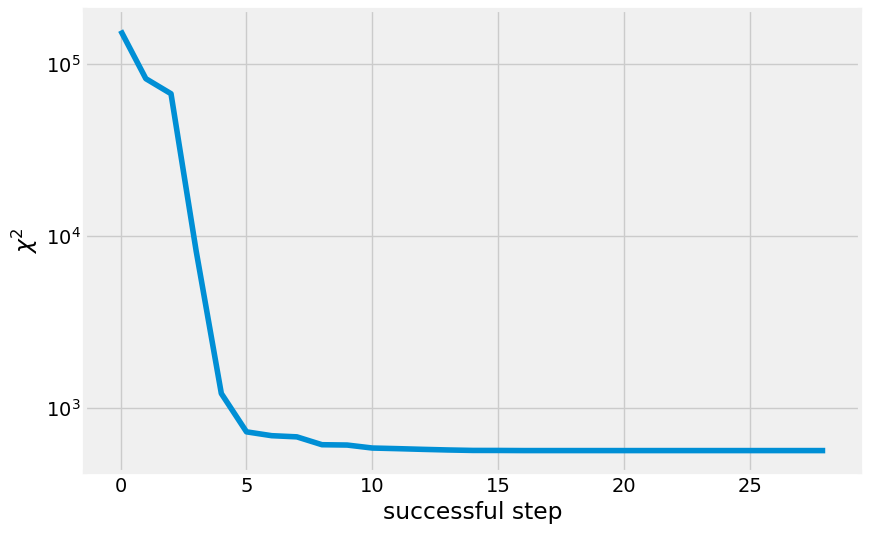

Best values: h = 0.7000965070758617 , Omega_M = 0.2791148272654712 , Omega_L = 0.7250083758655873


In [16]:
plt.figure(figsize=(10,6))
plt.style.use('fivethirtyeight')
plt.plot(chi2_total_list)
plt.xlabel("successful step")
plt.ylabel("$\chi^{2}$")
plt.yscale("log")
plt.xlabel("successful step")
ax = plt.gca()

#ax.set_ylim(5.6e2, 5.7e2)
plt.show()

print("Best values: h = {} , Omega_M = {} , Omega_L = {}".format(h_act, Omega_M_act, Omega_L_act))

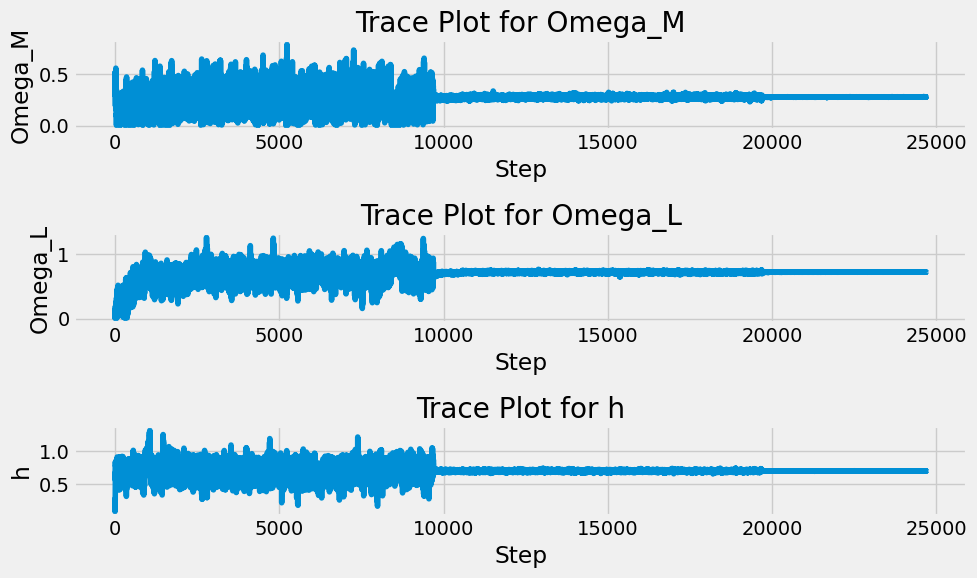

In [17]:

#plotting the trace plot to see how the components change with time
# Plot the trace for Omega_M
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(Omega_Mlist)
plt.xlabel("Step")
plt.ylabel("Omega_M")
plt.title("Trace Plot for Omega_M")

# Plot the trace for Omega_L
plt.subplot(3, 1, 2)
plt.plot(Omega_Llist)
plt.xlabel("Step")
plt.ylabel("Omega_L")
plt.title("Trace Plot for Omega_L")

# Plot the trace for h
plt.subplot(3, 1, 3)
plt.plot(hList)
plt.xlabel("Step")
plt.ylabel("h")
plt.title("Trace Plot for h")

plt.tight_layout()
plt.show()

After completion of the programme, your MC chain will (*hopefully*) look something like this: (note the repeated entry!)

`#Omega_m  Omega_L  h`

`0.297     0.703    0.698`

`0.285     0.715    0.701`

`0.285     0.715    0.701`

`0.288     0.712    0.699`

`...`

## <font color='deepskyblue'>Plotting: GetDist</font>

We will do the plots with [`GetDist`](https://getdist.readthedocs.io/en/latest/plot_gallery.html).

The plot gallery contains a lot of useful examples, you should be able to read them fairly easily and see which applies to your situation. Look for both (triangle) plots and for parameter estimation.

Note that many `GetDist` functions require arguments of type `MCSamples`; make sure you convert your lists accordingly.

<font color='deepskyblue'>
Look at your results. Do you obtain $\Omega_\Lambda \neq 0$? To a high degree of significance?

If yes, then my dear friend, you have **DISCOVERED THE ACCELERATED EXPANSION OF THE UNIVERSE AND WON THE NOBEL PRIZE IN PHYSICS 2011!**
</font>

In [18]:
h = np.array(hList)
OmegaM = np.array(Omega_Mlist)
OmegaL = np.array(Omega_Llist)



Removed no burn in
0.67  <  h  <  0.73  at  68 % CL
0.22  <  OmegaM  <  0.3  at  68 % CL
0.64  <  OmegaL  <  0.74  at  68 % CL
-0.02  <  Omegak  <  0.11  at  68 % CL

 x


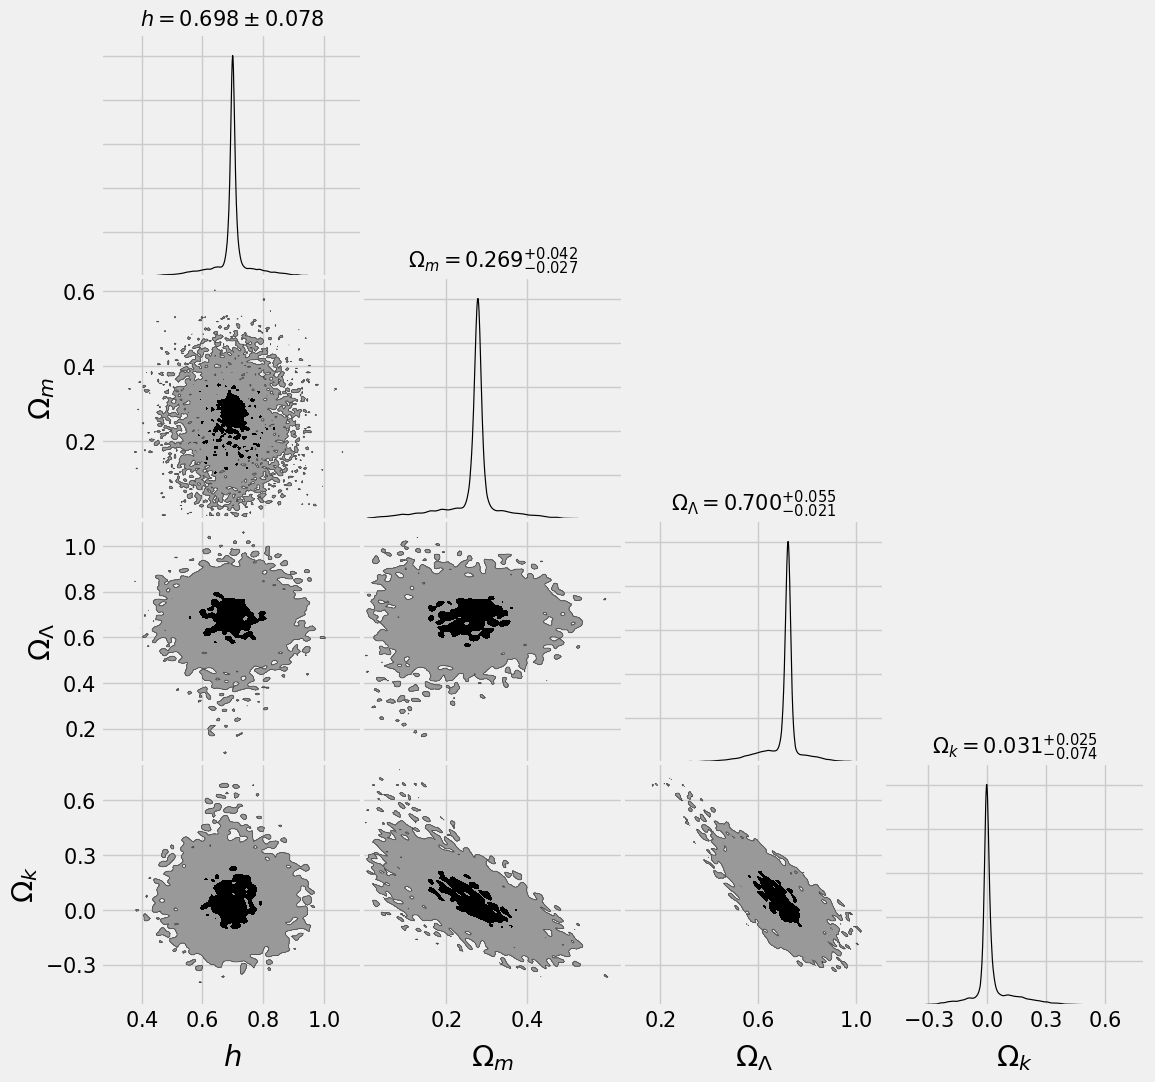

In [19]:
# These are just randomly generated values. YOU WILL HAVE TO USE THE RESULTS OF YOUR MCMC CHAIN!
# NB: when using your real data, consider removing some *burn-in* (look it up!)
# You can easily create new np.arrays that are functions of other np.arrays
Omegak = 1. - OmegaM - OmegaL

# Let's define variable names and labels
my_labels = [r'h', r'\Omega_m', r'\Omega_\Lambda', r'\Omega_k']
my_names = ['h', 'OmegaM', 'OmegaL', 'Omegak']
my_dim = len(my_names) # The number of variables we're plotting

# This creates a higher-dimensional array with all our data, shaped in the appropriate way...
my_samples = np.transpose(np.reshape([h, OmegaM, OmegaL, Omegak], (my_dim, len(h))))

# ... to create an "MCSamples" data type, which GetDist can use
my_samples = MCSamples(samples = my_samples, labels = my_labels, names = my_names)

# The usual 1-sigma confidence level. You can change to 2- or 3-sigma if you want
conf_level = 0.6827

# This prints a table with the 1D posteriors (confidence levels)
for nam in my_names:
    print(round(my_samples.confidence(nam,(1.-conf_level)/2.,upper=False),2), \
          " < ", nam , " < ", round(my_samples.confidence(nam,(1.-conf_level)/2.,upper=True),2),\
          " at " , int(100*conf_level),"\b% CL")
print("\n x")

#Triangle corner plot

c    = (0.,1.,0.)
j = plots.getSubplotPlotter(subplot_size=3)
j.settings.axes_labelsize = 22
j.settings.axes_fontsize = 16
j.triangle_plot(my_samples, filled = True, title_limit=1, contour_colors = ['black'] )

## <font color='deepskyblue'>Further Improvements</font>

There are many ways in which you can improve your code and/or your data visualisation. Some ideas, in random order:

* Modify your priors and compare your results. For instance:
  * Change to log-flat priors for $h$ and/or $\Omega_m$, namely displace them in log-space instead of linear space:
  $$
  \log(h_{\rm new}) = \log(h_{\rm old}) + \delta
  $$
  where $\delta$ a random variable of mean 0
  * Use priors from other cosmological probes, for example the [Planck 2018 results](https://arxiv.org/abs/1807.06209):
  $$
  \Omega_m = 0.315 \pm 0.007\,,~\dots
  $$
* Monitor acceptance ratio and $\chi^2$ as a function of step count
* Implement a Gelman-Rubin (or alternative) convergence test
* **Change colours and other properties of your triangle plot **
* Re-plot the data with your theoretical fits: you can try both your best fit, and some $1\sigma$ "error bars"
* Split your data in redshift bins and repeat the analysis for each bin individually. Nah fam
<br> _(What do you notice? Which redshift bins give us the most accurate detection of the cosmological parameters?)_

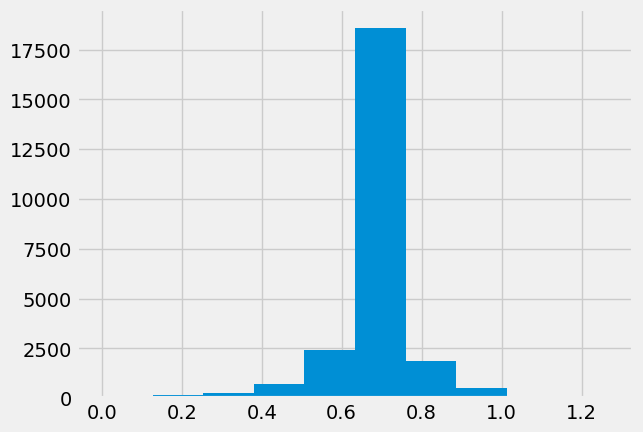

In [20]:
plt.hist(OmegaL)
plt.show()

In [21]:
# Extract the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
# Data are in columns, so we either slice it by columns: arr[:,n]...
zs = data[:,1] # redshift

# ...or transpose the array and then slice by row: arr_transposed[n]
distance_modulus = data.T[2] # distance modulus
error_distance_modulus = data.T[3] # errors on distance modulus = sigmas# Let's look at the data, just for fun.
# We can look both at the raw data (distance modulus) or calculate the luminosity distance
# Note that Numpy allows us to manipulate whole arrays at once with something like:
#     array_2 = some_function_of(array_1)

# luminosity distance in Mpc
luminosity_distance_pc = 1.E-5 * 10.**(distance_modulus / 5.)


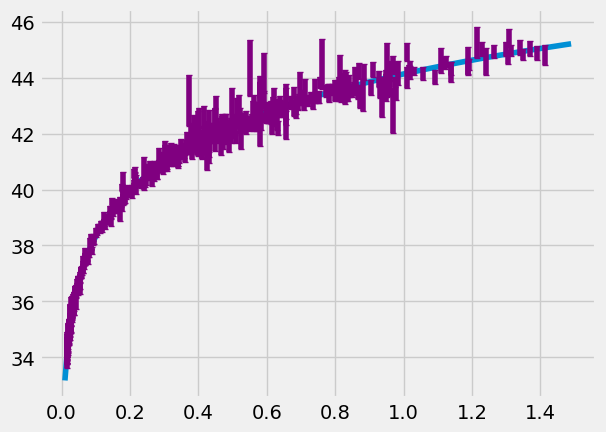

580


In [22]:
# Recommendation: you might want to try your functions here, and check that for Omega_m = 0.3 and Omega_L = 0.7 you get a decent match to the data
%matplotlib inline
#plt.scatter(zs,distance_modulus)

OmegaL = Omega_L_act
OmegaM = Omega_M_act
h0 = h_act
zvalues = np.arange(0.01, 1.5, 0.01)
DLS = []
for i in zvalues:
  DLS.append(dL(i,OmegaL, OmegaM, h0))

MUS = []

for i in zvalues:
  MUS.append(mu(i,OmegaL, OmegaM, h0))

plt.plot(zvalues, MUS)
plt.errorbar(zs, distance_modulus, yerr = error_distance_modulus, fmt=" ", ecolor= "purple", capsize= 2.5 )

plt.show()
# Plot distance modulus versus redshift (original data)
print(len(distance_modulus))

In [23]:
# You don't actually need to write your data on a file (you could just store it in some np.array)
# but it tends to be a good idea, so that you run a good, long MCMC once, and then you can do all the
# analysis later on at any time, without having to produce the data again

# Choose your favourite filename
filename = "MC_Chain_SNIa.txt"
file = open(filename, "w")

# A few thousand is a decent ballpark for the length of your MCMC chain
# NB: a few thousand *ACCEPTED* steps, not just attempted
N_steps = 2500

# Start from some very bad values, to show that the MCMC works anyway!
# (making sure you don't divide by zero anywhere...)
Omega_M = 0.1
Omega_L = 0.1
h = 0.1

# This is the main component of the exercise:
# PUT YOUR MCMC CODE HERE!

chi2_total_best = 999999999
chi2_total_list = []

hList = []
Omega_Mlist = []
Omega_Llist = []
i = 0
changing_random = 0.1
random_i = 1


#fig, ax = plt.subplots()

for i in range(N_steps):

    # pick a random step for all starting values

    if i % 250 == 0 and i != 0:
      print(i)
    if i % 10000 == 0 and i != 0:

      changing_random = changing_random/10

    Omega_M_new = Omega_M
    Omega_L_new = Omega_L
    h_new       = h       + np.random.normal(0, changing_random)
    if(Omega_M_new < 0.0) or (Omega_L_new < 0.0) or (h_new < 0.0) : continue

    # loop over all datapoints
    chi2_total = 0.

    for j in range(len(zs)) :
        mu_model = mu(zs[j], Omega_L_new, Omega_M_new, h_new)
        chi2 = (mu_model - distance_modulus[j])**2 / error_distance_modulus[j]**2
        chi2_total += chi2

    if np.isnan(chi2_total) : continue

    Omega_Mlist += [Omega_M_new]
    Omega_Llist += [Omega_L_new]
    hList += [h_new]

    chance = random.randint(0,1000)
    if(chi2_total < chi2_total_best or chance <=11) :
        Omega_M = Omega_M_new
        Omega_L = Omega_L_new
        h       = h_new

        if (chi2_total < chi2_total_best):
          h_act = h_new
          Omega_M_act = Omega_M_new
          Omega_L_act = Omega_L_new
          chi2_total_best = chi2_total
          chi2_total_list += [chi2_total]

          print("Values: h = {} , Omega_M = {} , Omega_L = {}".format(h_act, Omega_M_new, Omega_L_new ))
        else:
          random_i = i


    if i % random_i == 25:
      h         = h_act
      Omega_M   = Omega_M_act
      Omega_L   = Omega_L_act


file.close();


Values: h = 0.06879778865963962 , Omega_M = 0.1 , Omega_L = 0.1
Values: h = 0.32167210680596237 , Omega_M = 0.1 , Omega_L = 0.1
Values: h = 0.4335980649530673 , Omega_M = 0.1 , Omega_L = 0.1
Values: h = 0.5709177341153845 , Omega_M = 0.1 , Omega_L = 0.1
Values: h = 0.6293695905731286 , Omega_M = 0.1 , Omega_L = 0.1
Values: h = 0.639307125264369 , Omega_M = 0.1 , Omega_L = 0.1
Values: h = 0.6943000601590978 , Omega_M = 0.1 , Omega_L = 0.1
Values: h = 0.6642556991408789 , Omega_M = 0.1 , Omega_L = 0.1
Values: h = 0.6780849462517462 , Omega_M = 0.1 , Omega_L = 0.1
Values: h = 0.6754808918269094 , Omega_M = 0.1 , Omega_L = 0.1
250
500
750
1000
Values: h = 0.6750186585172788 , Omega_M = 0.1 , Omega_L = 0.1
1250
1500
1750
2000
Values: h = 0.6751454500477744 , Omega_M = 0.1 , Omega_L = 0.1
2250


In [24]:
OmegaM

0.279

In [25]:
# These are just randomly generated values. YOU WILL HAVE TO USE THE RESULTS OF YOUR MCMC CHAIN!
# NB: when using your real data, consider removing some *burn-in* (look it up!)
# You can easily create new np.arrays that are functions of other np.arrays
Omegak = 1. - OmegaM - OmegaL

# Let's define variable names and labels
my_labels = [r'h', r'\Omega_m', r'\Omega_\Lambda', r'\Omega_k']
my_names = ['h', 'OmegaM', 'OmegaL', 'Omegak']
my_dim = len(my_names) # The number of variables we're plotting

# This creates a higher-dimensional array with all our data, shaped in the appropriate way...
my_samples = np.transpose(np.reshape([h, OmegaM, OmegaL, Omegak], (my_dim, len(h))))

# ... to create an "MCSamples" data type, which GetDist can use
my_samples = MCSamples(samples = my_samples, labels = my_labels, names = my_names)

# The usual 1-sigma confidence level. You can change to 2- or 3-sigma if you want
conf_level = 0.6827

# This prints a table with the 1D posteriors (confidence levels)
for nam in my_names:
    print(round(my_samples.confidence(nam,(1.-conf_level)/2.,upper=False),2), \
          " < ", nam , " < ", round(my_samples.confidence(nam,(1.-conf_level)/2.,upper=True),2),\
          " at " , int(100*conf_level),"\b% CL")
print("\n x")

#Triangle corner plot

c    = (0.,1.,0.)
j = plots.getSubplotPlotter(subplot_size=3)
j.settings.axes_labelsize = 22
j.settings.axes_fontsize = 16
j.triangle_plot(my_samples, filled = True, title_limit=1, contour_colors = ['black'] )

TypeError: object of type 'float' has no len()